In [1]:
import requests
import pandas as pd
import psycopg2
import requests
import numpy as np
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold
import numpy as np
import csv
import joblib




In [2]:
from db_password import password  # Import the password function fromm a seperte file
pw = password()  # insert whatever your database pass word is here
db = "March Madness"  # Database name
host = "localhost"  # Database host
user = "postgres"  # Database user
port = "5432"  # Database port

def connecting():
    #Establish a connection to the PostgreSQL database.

    connection = None  # Initialize connection variable
    connection = psycopg2.connect(
        database=db,
        host=host,
        user=user,
        password=pw,
        port=port
    )  # Establish connection to the database
    return connection  # Return the connection object

def execute_query(connection, query):
 
    # Execute a SQL query on the database.
    try:
        cursor = connection.cursor()  # Create a cursor object
        cursor.execute(query)  # Execute the SQL query
        connection.commit()  # Commit the transaction
    except psycopg2.Error as e:
        print(f"Error executing query: {e}")  # Print error message
        connection.rollback()  # Rollback the transaction in case of error
    finally:
        cursor.close()  

def read_query(connection, query):
    """
    Execute a SQL query and fetch all results. 
    Returns:
        result (list): List of tuples containing the query results.
    """
    cursor = connection.cursor()  # Create a cursor object
    result = None  # Initialize result variable
    cursor.execute(query)  # Execute the SQL query
    result = cursor.fetchall()  # Fetch all results
    return result  # Return the query results

In [60]:

stats = []  # Initialize an empty list to store statistics data

# Loop through the years from 2008 to 2024
for year in range(2008, 2025):
    if year == 2020:
        pass  # Skip the year 2020 as that was cancelled due to COVID-19
    else:
        # Fetch data from the URL for the given year
        data = requests.get(f'https://barttorvik.com/teamslicejson.php?year={year}&csv=1&type=R') # I will be using barttorviik.com's pre tournament data for this
        data = StringIO(data.text)  # Convert the text data to a StringIO object
        data = pd.read_csv(data)  # Read the data into a pandas DataFrame
        stats.append(data)  # Append the DataFrame to the stats list
# Display the first 5 rows of the DataFrame for the year 2023 (index 15 in the list)
stats[15].head(5)

,UC Santa Barbara,104.51775657765,109.9586474894,0.35810581624159,14–15,14,29,53.3,50.6,39.7,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,2024,Unnamed: 31,Unnamed: 32,Unnamed: 33,-10.710547011203,74.4,68.2.1
0,Arkansas Pine Bluff,101.876386,118.931404,0.144297,9–18,9,27,51.5,52.6,40.2,...,NaN,NaN,NaN,2024,NaN,NaN,NaN,-13.243742,75.8,73.3
1,Portland St.,98.663983,105.167957,0.324286,14–15,14,29,46.8,52.0,34.3,...,NaN,NaN,NaN,2024,NaN,NaN,NaN,-11.094079,68.8,69.5
2,Indiana,109.726926,100.222017,0.739232,19–14,19,33,52.1,49.0,37.7,...,NaN,NaN,NaN,2024,NaN,NaN,NaN,-0.406769,66.4,75.0
3,Louisiana,105.522702,103.250109,0.562269,17–14,17,31,50.7,49.9,28.6,...,NaN,NaN,NaN,2024,NaN,NaN,NaN,-8.652084,73.8,71.7
4,Central Michigan,96.088762,104.008366,0.286839,17–14,17,31,46.8,47.3,27.4,...,NaN,NaN,NaN,2024,NaN,NaN,NaN,-8.265146,66.1,74.4


In [5]:
stats_2=[]
for i in range(len(stats)):
    new_data=stats[i].copy()
    stats_2.append(new_data)
print(len(stats_2))
# creating a backup copy of the data

16


In [6]:
drops= [33, 32, 31, 29, 28, 27, 15 ]
for i in range (len(stats_2)):
    df=stats_2[i]
    df.drop(df.columns[drops], axis=1, inplace=True)
print(len(stats_2[0].columns))
# dropping the columns that are null as well as column 15 because it was not clear what the data in that column was meant to represent

30


In [7]:
df=stats_2[15]
columns = df.columns.tolist()  
columns[29] = 67.2
df.columns = columns
df=stats_2[2]
columns=df.columns.tolist()
columns[25]=67.6
df.columns=columns

df_2=stats_2[10]
columns=df_2.columns.tolist()
columns[22]=54.8
df_2.columns=columns

df_3=stats_2[11]
columns=df_3.columns.tolist()
columns[25]=65.6
df_3.columns=columns

# some of the data sets had an issue where their was a double decimal in the column name so I had to fix that

In [8]:
def create_csvs(starting_year, i):
    """
    Create CSV files from a list of DataFrames starting from a given year.
    
    Args:
        starting_year (int): The year to start creating CSV files from.
        i (int): The starting index in the stats_2 list.
    """
    while i < len(stats_2):  # Loop until the end of the stats_2 list
        if starting_year == 2020:
            starting_year += 1  # Skip the year 2020
            continue  # Continue to the next iteration

        df = stats_2[i]  # Get the DataFrame at index i
        df.to_csv(f'stats_{starting_year}.csv', index=False)  # Save the DataFrame to a CSV file

        starting_year += 1  # Increment the year
        i += 1  # Increment the index

# Call the function to create CSV files starting from the year 2008 and index 0
create_csvs(2008, 0)

In [9]:
def drop_all_tables(starting_year):
    """
    Drop all tables from the database starting from a given year up to 2024.
    
    Args:
        starting_year (int): The year to start dropping tables from.
        i (int): The starting index (not used in this function).
    """
    while starting_year < 2025:  # Loop until the year 2024
        table_name = f'stats_{starting_year}'  # Construct the table name based on the year
        if starting_year == 2020:
            starting_year += 1  # Skip the year 2020
            continue  # Continue to the next iteration

        drop_table = f'''DROP TABLE {table_name}; '''  # SQL query to drop the table
        connection = connecting()  # Establish a connection to the database
        execute_query(connection, drop_table)  # Execute the drop table query

        starting_year += 1  # Increment the year

# Call the function to drop all tables starting from the year 2008
drop_all_tables(2008)

# this function was used to drop all stats_tables for the database whenever I needed to rerun the code

In [10]:
def create_tables(starting_year, i): # creating a function to create tables in the database for every csv file
    while i < len(stats_2):
        if starting_year == 2020:
            starting_year += 1 
            continue  
    # running a while loop to go through all the csv files (skipping 2020 as usual)
        table_name = f'stats_{starting_year}'
        csv_path = f'C:\\Users\\natha\\March Madness\\stats_{starting_year}.csv'

        create_table = f'''
        CREATE TABLE {table_name}  (
            school text,
            adjo numeric(16,12),
            adjd numeric (16,12),
            barthag numeric (15,12),
            record text,
            wins int,
            games_played int,
            efg_percentage numeric (3,1),
            efgd_percentage numeric (3,1),
            ftr numeric (3,1),
            ftrd numeric (3,1),
            to_percentage numeric (3,1),
            to_percentage_def numeric (3,1),
            orb_percentage numeric (3,1),
            drb_percentage numeric (3,1),
            two_point_percentage numeric (3,1),
            two_point_percentage_def numeric (3,1),
            three_point_percentage numeric (3,1),
            three_point_percentage_def numeric (3,1),
            def_block_percentage numeric (3,1),
            off_block_percentage numeric (3,1),
            ast_rate_off numeric (3,1),
            ast_rate_def numeric (3,1),
            three_pt_rate_off numeric (3,1),
            three_pt_rate_def numeric (3,1),
            adj_tempo numeric (3,1),
            year int,
            wab numeric (15, 12),
            ft_percentage numeric (3,1),
            ft_percentage_def numeric (3,1)
        ); 
        '''
        # creating a variable with the sql syntax to create a table
        copy = f'''
        COPY {table_name}
        FROM '{csv_path}'
        WITH (FORMAT CSV, HEADER FALSE);
        '''
        # creating a variable with the sql syntax to import our csv files
        connection = connecting()
        execute_query(connection, create_table)

        execute_query(connection, copy)
        print(read_query(connection, f'SELECT * FROM {table_name} limit 1;'))  
        # using our earlier functions to execute and read the sql commands
        i += 1
        starting_year += 1

    connection.close() 
create_tables(2008, 0)

[('Jackson St.', Decimal('91.594510994824'), Decimal('107.712378104380'), Decimal('0.134229205980'), '14–20', 14, 34, Decimal('45.5'), Decimal('51.4'), Decimal('41.9'), Decimal('40.1'), Decimal('22.6'), Decimal('22.5'), Decimal('33.7'), Decimal('33.9'), Decimal('44.8'), Decimal('50.3'), Decimal('31.7'), Decimal('35.8'), Decimal('8.1'), Decimal('9.9'), Decimal('50.7'), Decimal('53.6'), Decimal('27.3'), Decimal('31.0'), Decimal('72.4'), 2008, Decimal('-15.235788873297'), Decimal('67.5'), Decimal('67.3'))]
[('UC Santa Barbara', Decimal('97.979687136664'), Decimal('98.208123980321'), Decimal('0.493305221472'), '15–15', 15, 30, Decimal('49.8'), Decimal('51.2'), Decimal('39.5'), Decimal('39.3'), Decimal('23.3'), Decimal('24.2'), Decimal('32.7'), Decimal('31.5'), Decimal('49.5'), Decimal('48.6'), Decimal('33.5'), Decimal('37.3'), Decimal('7.7'), Decimal('5.8'), Decimal('54.9'), Decimal('57.4'), Decimal('30.2'), Decimal('35.6'), Decimal('66.5'), 2009, Decimal('-8.679040744835'), Decimal('69.4'

In [11]:
# the dataset was obtained here https://www.kaggle.com/datasets/nishaanamin/march-madness-data?select=Barttorvik+Away.csv
# in excel I removed all the unnessecary contents and manually added the 2024 results
# I then change the round column into something that is easier to preform analysis with
results = pd.read_csv('Barttorvik Away.csv')

def change_win_columns():
    """
    Modify the 'ROUND' column in the DataFrame to represent March Madness wins.
    
    - Replace values in the 'ROUND' column according to the specified mapping.
    - Rename the 'ROUND' column to 'March Madness Wins'.
    - Sort the DataFrame by the 'YEAR' column in ascending order.
    
    Returns:
        results (pd.DataFrame): The modified DataFrame.
    """
    # Define a dictionary to replace 'ROUND' values with corresponding win counts
    replace = {68: 0, 64: 0, 32: 1, 16: 2, 8: 3, 4: 4, 2: 5, 1: 6}
    
    # Replace the 'ROUND' values in the DataFrame using the defined dictionary
    results['ROUND'] = results['ROUND'].replace(replace)
    
    # Rename the 'ROUND' column to 'March Madness Wins'
    results.rename({"ROUND": "March Madness Wins"}, axis=1, inplace=True)
    
    # Sort the DataFrame by the 'YEAR' column in ascending order
    results.sort_values(by='YEAR', ascending=True, inplace=True)
    
    return results  # Return the modified DataFrame

# Call the function and print the modified DataFrame
print(change_win_columns())

      YEAR             TEAM  SEED  March Madness Wins
1078  2008           Xavier     3                   3
1077  2008        Wisconsin     3                   2
1076  2008         Winthrop    13                   0
1043  2008         Miami FL     7                   1
1044  2008     Michigan St.     5                   2
...    ...              ...   ...                 ...
39    2024           Nevada    10                   0
35    2024  Mississippi St.     8                   0
38    2024         Nebraska     8                   0
37    2024     Morehead St.    14                   0
36    2024      Montana St.    16                   0

[1079 rows x 4 columns]


In [12]:
def drop_table(table):
    drop_table=f'''DROP TABLE {table};'''
    connection=connecting()
    execute_query(connection, drop_table)
drop_table('results')
# a genreal function to drop any table in the database, here I use it to drop the results table while rerunning the code

In [13]:
def create_results_table():
    """
    Create a 'results' table in the database and populate it with data from a CSV file.
    
    - Save the 'results' DataFrame to a CSV file.
    - Define the SQL command to create the 'results' table.
    - Define the SQL command to copy data from the CSV file into the 'results' table.
    - Establish a connection to the database.
    - Execute the SQL commands to create the table and copy the data.
    - Print the first row of the 'results' table to verify the data import.
    - Close the database connection.
    """
    # Save the 'results' DataFrame to a CSV file
    results.to_csv('results.csv')
    
    # Define the SQL command to create the 'results' table
    create_results = '''
    CREATE TABLE results (
    id int,
    year int,
    team text, 
    seed int,
    march_madness_wins int);
    '''
    
    # Define the SQL command to copy data from the CSV file into the 'results' table
    copy_results = '''
    COPY results
    FROM 'C:\\Users\\natha\\March Madness\\Results.csv'
    WITH (FORMAT CSV, HEADER);
    '''
    
    # Establish a connection to the database
    connection = connecting()
    
    # Execute the SQL command to create the 'results' table
    execute_query(connection, create_results)
    
    # Execute the SQL command to copy data from the CSV file into the 'results' table
    execute_query(connection, copy_results)
    
    # Print the first row of the 'results' table to verify the data import
    print(read_query(connection, 'SELECT * FROM results limit 1;'))
    
    # Close the database connection
    connection.close()

# Call the function to create the 'results' table and populate it with data
create_results_table()

[(1078, 2008, 'Xavier', 3, 3)]


In [73]:
# Initialize an empty dictionary to store R-squared values
r2_values = {}

def regression(metric):
    """
    Perform a regression analysis on a specified metric against March Madness wins.
    
    Args:
        metric (str): The metric to be analyzed (e.g., 'seed', 'ftr', etc.).
    """
    stat = []  # Initialize an empty list to store query results
    queries = []  # Initialize an empty list to store SQL queries
    year = 2008  # Starting year for the analysis
    
    # Loop through the years from 2008 to 2024
    while year < 2025:
        if year == 2020:
            year += 1  # Skip the year 2020
            continue  # Continue to the next iteration
        
        table_name = f'stats_{year}'  # Construct the table name based on the year
        
        # Construct the SQL query based on the metric
        if metric == 'seed':
            query = f'''
            SELECT s.school, s.year, r.{metric}, r.march_madness_wins 
            FROM stats_{year} AS s 
            JOIN results AS r 
            ON s.school = r.team AND s.year = r.year
            '''
        else:
            query = f'''
            SELECT s.school, s.year, s.{metric}, r.march_madness_wins 
            FROM stats_{year} AS s 
            JOIN results AS r 
            ON s.school = r.team AND s.year = r.year
            '''
        
        queries.append(query)  # Append the query to the list of queries
        year += 1  # Increment the year
    
    # Combine all queries into a single query using UNION ALL
    final_query = "UNION ALL ".join(queries)
    
    connection = connecting()  # Establish a connection to the database
    execute_query(connection, final_query)  # Execute the combined query
    stat_results = read_query(connection, final_query)  # Fetch the query results
    
    # Process the query results
    for result in stat_results:
        result = list(result)  # Convert the result tuple to a list
        stat.append(result)  # Append the result to the stat list
    
    # Create a DataFrame from the query results
    stat_df = pd.DataFrame(stat)
    
    # Rename the DataFrame columns for clarity
    stat_df.rename({2: metric, 3: 'March Madness Wins'}, inplace=True, axis=1)
    
    # Extract the metric and March Madness wins as numpy arrays
    x = stat_df[metric].values
    y = stat_df['March Madness Wins'].values
    
    # Reshape the metric array for the regression model
    x = x.reshape(-1, 1)
    
    # Initialize and fit the linear regression model
    reg = LinearRegression()
    reg=reg.fit(x,y)
    r2_score=reg.score(x,y)
    r2_values[metric]=r2_score #adding the r2 values to a dictionary so we can preform analysis on it
    return stat_df
  

In [68]:
stats=['adjo', 'adjd', 'barthag', 'wins', 'efg_percentage','efgd_percentage','ftr','ftrd','to_percentage_def',
'to_percentage','orb_percentage','drb_percentage','two_point_percentage','two_point_percentage_def',
'three_point_percentage_def','three_point_percentage','def_block_percentage', 'off_block_percentage', 'ast_rate_off',
'ast_rate_def', 'three_pt_rate_off', 'three_pt_rate_def', 'adj_tempo', 'seed'] # creating a list of all the stats we want to preform regression on
for stat in stats:
    regression(stat)
print(r2_values)

{'adjo': 0.215296193939426, 'adjd': 0.1593629420915017, 'barthag': 0.1940550479719717, 'wins': 0.16609025211809447, 'efg_percentage': 0.035601105252983656, 'efgd_percentage': 0.04267433228859552, 'ftr': 0.004201468226952332, 'ftrd': 0.024157119616209366, 'to_percentage_def': 0.0020976402103043412, 'to_percentage': 0.028560629255152126, 'orb_percentage': 0.04798291944190236, 'drb_percentage': 0.001685822682699456, 'two_point_percentage': 0.03557370181405617, 'two_point_percentage_def': 0.03494379713739848, 'three_point_percentage_def': 0.01393661345399555, 'three_point_percentage': 0.01004785587060708, 'def_block_percentage': 0.03631419821254678, 'off_block_percentage': 0.012014307585802242, 'ast_rate_off': 0.0062828986389935615, 'ast_rate_def': 0.0017796544953450066, 'three_pt_rate_off': 0.000498729822181021, 'three_pt_rate_def': 0.000914207538641798, 'adj_tempo': 0.0005421260152324026, 'seed': 0.3230085047579512}


In [69]:
def dict_to_df(dictionary):
    """
    Convert a dictionary to a pandas DataFrame, sort it by the 'Accuracy' column, and return the DataFrame.
    
    Args:
        dictionary (dict): A dictionary where keys are model names and values are accuracy scores.
    
    Returns:
        metrics_df (pd.DataFrame): A DataFrame sorted by the 'Accuracy' column in descending order.
    """
    # Convert the dictionary items to a list of tuples
    metrics_list = list(dictionary.items())
    
    # Create a DataFrame from the list of tuples with columns 'Model' and 'Accuracy'
    metrics_df = pd.DataFrame(metrics_list, columns=['Model', 'Accuracy'])
    
    # Sort the DataFrame by the 'Accuracy' column in descending order
    metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
    
    return metrics_df  # Return the sorted DataFrame

# Print the DataFrame created from the r2_values dictionary
print(dict_to_df(r2_values))

                         Model  Accuracy
23                        seed  0.323009
0                         adjo  0.215296
2                      barthag  0.194055
3                         wins  0.166090
1                         adjd  0.159363
10              orb_percentage  0.047983
5              efgd_percentage  0.042674
16        def_block_percentage  0.036314
4               efg_percentage  0.035601
12        two_point_percentage  0.035574
13    two_point_percentage_def  0.034944
9                to_percentage  0.028561
7                         ftrd  0.024157
14  three_point_percentage_def  0.013937
17        off_block_percentage  0.012014
15      three_point_percentage  0.010048
18                ast_rate_off  0.006283
6                          ftr  0.004201
8            to_percentage_def  0.002098
19                ast_rate_def  0.001780
11              drb_percentage  0.001686
21           three_pt_rate_def  0.000914
22                   adj_tempo  0.000542
20           thr

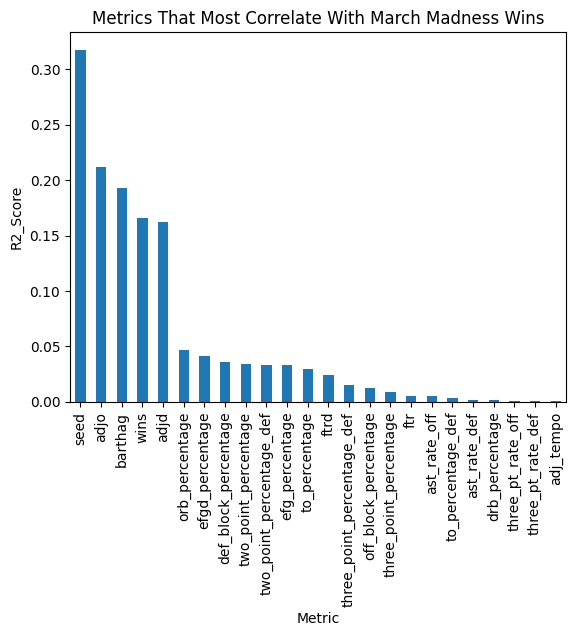

In [17]:
def r2_bar_graph():
    """
    Create a bar graph to visualize the R-squared values of different metrics.
    
    
    Returns:
        r2_bar (matplotlib.axes._subplots.AxesSubplot): The bar graph plot.
    """
    # Convert the r2_values dictionary to a DataFrame and plot it as a bar graph
    r2_bar = dict_to_df(r2_values).plot(
        kind='bar', 
        x='Model', 
        y='Accuracy', 
        title='Metrics That Most Correlate With March Madness Wins', 
        legend=False
    )
    
    # Set the x-label of the bar graph
    r2_bar.set_xlabel('Metric')
    
    # Set the y-label of the bar graph
    r2_bar.set_ylabel('R2_Score')
    
    return r2_bar  # Return the bar graph plot

# Create the bar graph by calling the r2_bar_graph function
bar = r2_bar_graph()

# Display the bar graph
plt.show(bar)
# As seen from the bar graph, the metric that most correlates with March Madness wins is the seed of the team
# some more interesting findings are offense out preforming defense and orb percentage being the most important stat that is not a combination of other factors

<Axes: title={'center': 'barthag vs March Madness Wins'}, xlabel='Percentile', ylabel='March Madness Wins'>

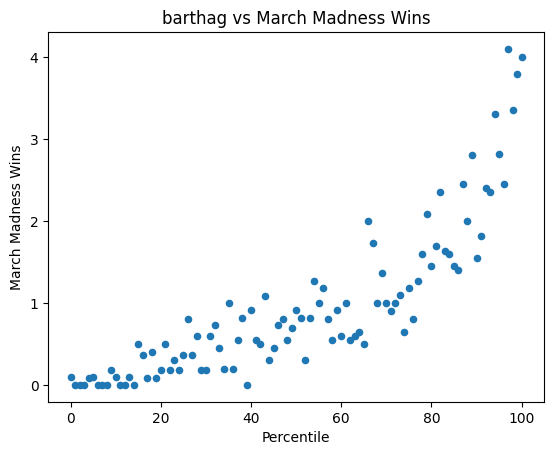

In [75]:
# Initialize an empty list to store percentiles
percentile_list = []

# Populate the percentile_list with values from 0 to 100
for i in range(0, 101):
    percentile_list.append(i)

def make_win_scatter(metric, percentiles):
    """
    Create a scatter plot of a given metric against March Madness wins.
    
    Args:
        metric (str): The metric to be analyzed (e.g., 'barthag').
        percentiles (list): A list of percentiles to be included in the scatter plot.
    
    Returns:
        scatter (matplotlib.axes._subplots.AxesSubplot): The scatter plot.
    """
    # Perform regression analysis on the specified metric
    whole_stat_df = regression(metric)
    
    # Convert the metric column to float
    whole_stat_df[metric] = whole_stat_df[metric].apply(float)
    
    # Calculate the percentile rank for the metric and convert to integer
    whole_stat_df['percentile'] = whole_stat_df[metric].rank(pct=True) * 100
    whole_stat_df['percentile'] = whole_stat_df['percentile'].astype(int)  # Convert to integer
    
    # Group by percentile and calculate the mean March Madness wins, rounded to 2 decimal places
    whole_stat_df_graph = whole_stat_df.groupby('percentile')[['March Madness Wins']].mean().round(2)
    whole_stat_df_graph = whole_stat_df_graph.reset_index()  
    
    # Select only the rows with percentiles in the provided list
    selected_percentiles = whole_stat_df_graph[whole_stat_df_graph['percentile'].isin(percentiles)]
    
    # Create a scatter plot of percentile vs March Madness wins
    scatter = selected_percentiles.plot(
        kind='scatter', 
        x='percentile', 
        y='March Madness Wins',
        title=f'{metric} vs March Madness Wins'
    )
    
    # Set the x-label and y-label of the scatter plot
    scatter.set_xlabel('Percentile')
    scatter.set_ylabel('March Madness Wins')
    
    return scatter  # Return the scatter plot

# Call the function to create a scatter plot for the 'barthag' metric using the percentile_list
make_win_scatter('barthag', percentile_list)
# This function does not work with the seed metric

In [19]:
def score(y_train, y_pred):
    """
    Calculate the R-squared score for the given true and predicted values.
    
    Args:
        y_train (array-like): True values.
        y_pred (array-like): Predicted values.
    
    Returns:
        float: R-squared score.
    """
    return r2_score(y_train, y_pred)

# Seed value for reproducibility
seed = 6

# Dictionary of regression models to be used
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Elastic Net': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'Bayesian Ridge': BayesianRidge(),
    'Huber Regression': HuberRegressor(max_iter=6000),
}

def get_all_data():
    """
    Generate a SQL query to retrieve all data from the stats tables and join with results.
    
    Returns:
        str: The final SQL query string.
    """
    queries = []  # List to store individual year queries
    i = 0  # Counter for the number of years processed
    starting_year = 2008  # Starting year for the data retrieval
    
    # Loop through the years from 2008 to 2024 (excluding 2020)
    while i < 16:
        table_name = f'stats_{starting_year}'  # Construct the table name based on the year
        if starting_year == 2020:
            starting_year += 1  # Skip the year 2020
            continue  # Continue to the next iteration
        
        # SQL query to select distinct rows from the stats table and join with results
        query = f'''
        SELECT DISTINCT s.*, r.march_madness_wins, r.year
        FROM stats_{starting_year} AS s 
        JOIN results AS r 
        ON s.school = r.team AND s.year = r.year
        '''
        queries.append(query)  # Append the query to the list of queries
        i += 1  # Increment the counter
        starting_year += 1  # Increment the year
    
    # Combine all individual year queries into a single query using UNION ALL
    final_query = "UNION ALL ".join(queries)
    return final_query  # Return the final combined query

def load_data():
    """
    Load data from the database by executing the generated SQL query.
    
    Returns:
        list: List of tuples containing the query results.
    """
    connection = connecting()  # Establish a connection to the database
    execute_query(connection, get_all_data())  # Execute the combined query
    stat_results = read_query(connection, get_all_data())  # Fetch the query results
    return stat_results  # Return the query results

def get_array(query):
    """
    Convert the query results into a list of lists.
    
    Args:
        query (function): Function that returns the query results.
    
    Returns:
        list: List of lists containing the query results.
    """
    stat = []  # Initialize an empty list to store the results
    for result in query():  # Iterate over each result in the query results
        result = list(result)  # Convert the result tuple to a list
        stat.append(result)  # Append the result list to the stat list
        # Convert the list of statistics to a pandas DataFrame
    stat_df = pd.DataFrame(stat)

# Convert the DataFrame to a numpy array
    array = stat_df.values

# Return the numpy array
    return array

def get_x(data):
    """
    Extract the feature matrix (X) from the data.
    
    Args:
        data (function): Function that returns the query results.
    
    Returns:
        np.ndarray: Feature matrix (X).
    """
    array = get_array(data)  # Get the array from the data
    # Concatenate specific columns to form the feature matrix
    x = np.concatenate((array[:, 1:4], array[:, 5:26], array[:, 27:29]), axis=1)
    x = np.array(x, dtype=float)  # Convert the feature matrix to float type
    return x  # Return the feature matrix

def get_y():
    """
    Extract the target vector (y) from the data.
    
    Returns:
        np.ndarray: Target vector (y).
    """
    y = get_array(load_data)[:, 30]  # Get the target column from the data
    y = np.array(y, dtype=float)  # Convert the target vector to float type
    return y  # Return the target vector

def basic_regression_testing(splits):
    """
    Perform basic regression testing using K-Fold cross-validation.
    
    Args:
        splits (int): Number of splits for K-Fold cross-validation.
    
    Returns:
        dict: Dictionary containing the average R-squared score for each model.
    """
    model_metrics = {}  # Initialize an empty dictionary to store model metrics
    kf = KFold(n_splits=splits, shuffle=True, random_state=seed)  # Initialize K-Fold cross-validation
    
    # Iterate over each model in the models dictionary
    for model_name, model in models.items():
        fold_accuracies = []  # Initialize an empty list to store fold accuracies
        
        # Perform K-Fold cross-validation
        for train_index, val_index in kf.split(get_x(load_data)):
            x_train, x_val = get_x(load_data)[train_index], get_x(load_data)[val_index]  # Split the feature matrix
            y_train, y_val = get_y()[train_index], get_y()[val_index]  # Split the target vector
            model.fit(x_train, y_train)  # Fit the model on the training data
            preds = model.predict(x_val)  # Predict on the validation data
            accuracy = score(y_val, preds)  # Calculate the R-squared score
            fold_accuracies.append(accuracy)  # Append the accuracy to the list
        
        avg_accuracy = np.mean(fold_accuracies)  # Calculate the average accuracy
        model_metrics[model_name] = avg_accuracy  # Store the average accuracy in the dictionary
    
    return model_metrics  # Return the dictionary of model metrics

# Convert the dictionary of model metrics to a DataFrame and print it
dict_to_df(basic_regression_testing(5)) #Linear regression preformed the best before any further analysis
    

,Model,Accuracy
0,Linear Regression,0.372988
5,Huber Regression,0.368139
4,Bayseian Ridge,0.364558
1,Ridge Regression,0.362713
3,Elastic Net,0.297475
2,Lasso,0.278040


In [20]:
def clip_predictions(model, X, min_val=0, max_val=6):
    """
    Clip the predictions of a model to a specified range.
    
    Args:
        model (object): The regression model used for predictions.
        X (np.ndarray): The feature matrix.
        min_val (int, optional): The minimum value to clip to. Defaults to 0.
        max_val (int, optional): The maximum value to clip to. Defaults to 6.
    
    Returns:
        np.ndarray: The clipped predictions.
    """
    predictions = model.predict(X)  # Make predictions using the model
    return np.clip(predictions, min_val, max_val)  # Clip the predictions to the specified range

def clipped_testing(splits):
    """
    Perform regression testing with clipped predictions using K-Fold cross-validation.
    
    Args:
        splits (int): Number of splits for K-Fold cross-validation.
    
    Returns:
        dict: Dictionary containing the average R-squared score for each model.
    """
    model_metrics = {}  # Initialize an empty dictionary to store model metrics
    kf = KFold(n_splits=splits, shuffle=True, random_state=seed)  # Initialize K-Fold cross-validation
    
    # Iterate over each model in the models dictionary
    for model_name, model in models.items():
        fold_accuracies = []  # Initialize an empty list to store fold accuracies
        
        # Perform K-Fold cross-validation
        for train_index, val_index in kf.split(get_x(load_data)):
            x_train, x_val = get_x(load_data)[train_index], get_x(load_data)[val_index]  # Split the feature matrix
            y_train, y_val = get_y()[train_index], get_y()[val_index]  # Split the target vector
            model.fit(x_train, y_train)  # Fit the model on the training data
            
            preds = model.predict(x_val)  # Predict on the validation data
            preds = clip_predictions(model, x_val)  # Clip the predictions to the specified range
            accuracy = score(y_val, preds)  # Calculate the R-squared score
            fold_accuracies.append(accuracy)  # Append the accuracy to the list
        
        avg_accuracy = np.mean(fold_accuracies)  # Calculate the average accuracy
        model_metrics[model_name] = avg_accuracy  # Store the average accuracy in the dictionary
    
    return model_metrics  # Return the dictionary of model metrics

# Convert the dictionary of model metrics to a DataFrame and print it
dict_to_df(clipped_testing(5)) # models preform slighltly better when the predictions are clipped

,Model,Accuracy
0,Linear Regression,0.379520
5,Huber Regression,0.375182
4,Bayseian Ridge,0.373213
1,Ridge Regression,0.372252
3,Elastic Net,0.309018
2,Lasso,0.282288


In [21]:
def best_selector_testing(start, stop, splits):
    """
    Perform regression testing using SelectKBest feature selection and K-Fold cross-validation.
    
    Args:
        start (int): The starting number of features to select.
        stop (int): The stopping number of features to select.
        splits (int): Number of splits for K-Fold cross-validation.
    
    Returns:
        dict: Dictionary containing the average R-squared score for each model and number of features.
    """
    model_metrics = {}  # Initialize an empty dictionary to store model metrics
    i = start  # Initialize the feature selection counter
    
    # Loop through the range of features to select
    while i < int(stop):
        kf = KFold(n_splits=splits, shuffle=True, random_state=seed)  # Initialize K-Fold cross-validation
        selector = SelectKBest(score_func=f_regression, k=i)  # Initialize SelectKBest with f_regression score function
        x = get_x()  # Get the feature matrix
        x = selector.fit_transform(x, get_y())  # Fit and transform the feature matrix using SelectKBest
        
        # Iterate over each model in the models dictionary
        for model_name, model in models.items():
            fold_accuracies = []  # Initialize an empty list to store fold accuracies
            
            # Perform K-Fold cross-validation
            for train_index, val_index in kf.split(get_x()):
                x_train, x_val = x[train_index], x[val_index]  # Split the feature matrix
                y_train, y_val = get_y()[train_index], get_y()[val_index]  # Split the target vector
                model.fit(x_train, y_train)  # Fit the model on the training data
                
                preds = model.predict(x_val)  # Predict on the validation data
                preds = clip_predictions(model, x_val)  # Clip the predictions to the specified range
                accuracy = score(y_val, preds)  # Calculate the R-squared score
                fold_accuracies.append(accuracy)  # Append the accuracy to the list
            
            avg_accuracy = np.mean(fold_accuracies)  # Calculate the average accuracy
            model_metrics[f'{model_name}, {i}'] = avg_accuracy  # Store the average accuracy in the dictionary
        
        i += 1  # Increment the feature selection counter
    
    return model_metrics  # Return the dictionary of model metrics

# Convert the dictionary of model metrics to a DataFrame and print it
dict_to_df(best_selector_testing(1, 27, 5)) # Bayseian Ridge with 7 selectors is our best preforming model

,Model,Accuracy
40,"Bayseian Ridge, 7",0.396656
28,"Bayseian Ridge, 5",0.396511
36,"Linear Regression, 7",0.396495
46,"Bayseian Ridge, 8",0.396298
24,"Linear Regression, 5",0.396281
...,...,...
8,"Lasso, 2",0.281175
14,"Lasso, 3",0.281175
2,"Lasso, 1",0.279522
11,"Huber Regression, 2",0.273794


In [22]:
def selector_df():
    """
    Create a DataFrame from the results of the best_selector_testing function and process it.
    
    - Convert the dictionary of model metrics to a DataFrame.
    - Split the 'Model' column into 'Model_Name' and 'Number of Selectors'.
    - Drop the original 'Model' column.
    
    Returns:
        pd.DataFrame: The processed DataFrame with model names and number of selectors.
    """
    # Convert the dictionary of model metrics to a DataFrame
    metrics_df = dict_to_df(best_selector_testing(1, 25, 5))
    
    # Split the 'Model' column into 'Model_Name' and 'Number of Selectors'
    metrics_df[['Model_Name', 'Number of Selectors']] = metrics_df['Model'].str.split(', ', expand=True)
    
    # Drop the original 'Model' column
    metrics_df.drop('Model', axis=1, inplace=True)
    
    return metrics_df  # Return the processed DataFrame

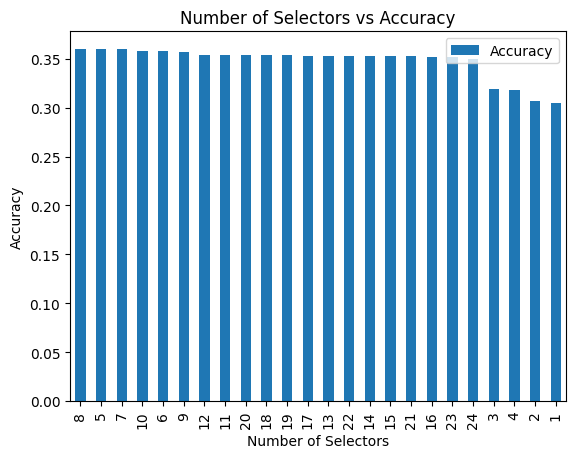

In [23]:
def best_selector_graph():
    """
    Create a bar graph to visualize the relationship between the number of selectors and accuracy.
    
    - Retrieve and process the metrics DataFrame.
    - Group the DataFrame by 'Number of Selectors' and calculate the mean accuracy.
    - Sort the DataFrame by accuracy in descending order.
    - Plot the DataFrame as a bar graph.
    - Set the title, x-label, and y-label of the graph.
    
    Returns:
        graph (matplotlib.axes._subplots.AxesSubplot): The bar graph plot.
    """
    metrics_df = selector_df()  # Retrieve and process the metrics DataFrame
    
    # Group by 'Number of Selectors' and calculate the mean accuracy, rounded to 3 decimal places
    metrics_df = metrics_df.groupby('Number of Selectors')[['Accuracy']].mean().round(3)
    
    # Reset the index of the DataFrame
    metrics_df = metrics_df.reset_index()
    
    # Sort the DataFrame by accuracy in descending order
    metrics_df = metrics_df.sort_values(by='Accuracy', ascending=False)
    
    # Plot the DataFrame as a bar graph
    graph = metrics_df.plot(
        kind='bar', 
        x='Number of Selectors', 
        y='Accuracy', 
        title='Number of Selectors vs Accuracy'
    )
    
    # Set the x-label of the graph
    graph.set_xlabel('Number of Selectors')
    
    # Set the y-label of the graph
    graph.set_ylabel('Accuracy')
    
    return graph  # Return the bar graph plot

# Display the bar graph by calling the best_selector_graph function
plt.show(best_selector_graph())
# On average 8 selectors preformed the best, their is also a big jump in accuracy after using more than 4 selectors

In [28]:
def get_preds():
    """
    - Use the highest preforming model on previous test
    - Train the model on the selected features.
    - Clip the predictions to a specified range.
    - Save the trained model and selector to a file using joblib.
    
    Returns:
        np.ndarray: The clipped predictions.
    """
    model = BayesianRidge()  # Initialize the Bayesian Ridge regression model
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)  # Initialize K-Fold cross-validation
    selector = SelectKBest(score_func=f_regression, k=7)  # Initialize SelectKBest with f_regression score function
    x = get_x(load_data)  # Get the feature matrix
    x = selector.fit_transform(x, get_y())  # Fit and transform the feature matrix using SelectKBest
    model.fit(x, get_y())  # Train the model on the selected features
    preds = model.predict(x)  # Generate predictions
    preds = clip_predictions(model, x)  # Clip the predictions to the specified range
    joblib.dump((model, selector), 'march_madness.joblib')  # Save the model and selector to a file
    return preds  # Return the clipped predictions

def get_teams():
    """
    Retrieve the list of team names from the data.
    
    Returns:
        list: List of team names.
    """
    array = get_array(load_data)  # Get the array from the data
    teams = []  # Initialize an empty list to store team names
    for i in array:
        teams.append(i[0])  # Append the team name (first element) to the list
    return teams  # Return the list of team names

def get_year():
    """
    Retrieve the list of years from the data.
    
    Returns:
        list: List of years.
    """
    array = get_array(load_data)  # Get the array from the data
    years = []  # Initialize an empty list to store years
    for i in array:
        years.append(i[31])  # Append the year (32nd element) to the list
    return years  # Return the list of years

def compare_preds():
    """
    Compare the actual and predicted March Madness wins for each team.
    
    - Retrieve the actual values, predictions, team names, and years.
    - Create a list of team-year combinations.
    - Create a DataFrame to compare the actual and predicted values.
    
    Returns:
        pd.DataFrame: DataFrame containing the team-year combinations, actual values, and predicted values.
    """
    y_vals = get_y()  # Get the actual values
    preds = get_preds()  # Get the predictions
    schools = get_teams()  # Get the list of team names
    years = get_year()  # Get the list of years
    teams = []  # Initialize an empty list to store team-year combinations
    for school, year in zip(schools, years):
        teams.append(f'{year}, {school}')  # Append the team-year combination to the list
    # Create a DataFrame to compare the actual and predicted values
    comparison_df = pd.DataFrame({'Team': teams, 'Actual': y_vals, 'Predicted': preds})
    return comparison_df  # Return the comparison DataFrame

# Print the comparison DataFrame
print(compare_preds())

                       Team  Actual  Predicted
0     2008, Mississippi St.     1.0   0.457970
1            2008, Oklahoma     1.0   0.744294
2          2008, Kansas St.     1.0   1.169272
3           2008, Texas A&M     1.0   1.240434
4              2008, Baylor     0.0   0.639969
...                     ...     ...        ...
1057             2024, Yale     1.0   0.061403
1058    2024, Grambling St.     0.0   0.191727
1059     2024, Northwestern     1.0   0.725981
1060          2024, Houston     2.0   3.705229
1061         2024, Kentucky     0.0   1.138413

[1062 rows x 3 columns]


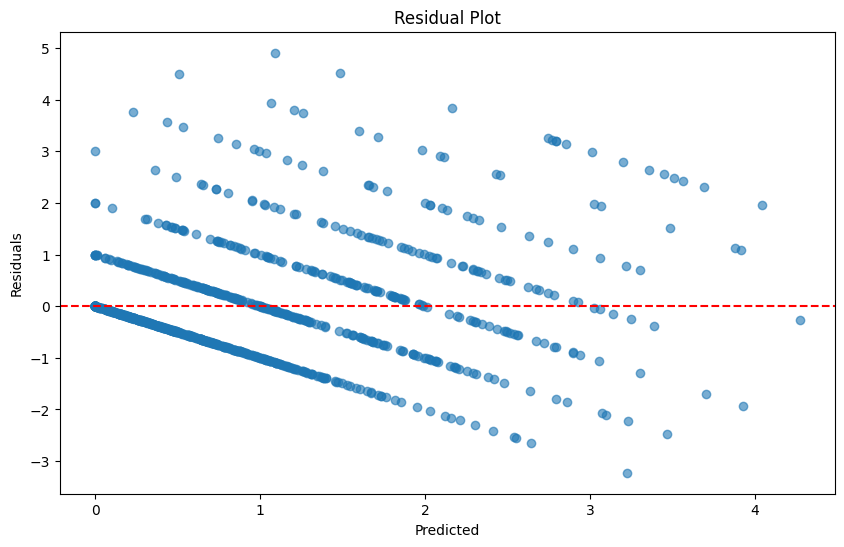

In [29]:
def residual_plot():
    """
    Create a residual plot to visualize the difference between actual and predicted values.
    
    - Retrieve the comparison DataFrame containing actual and predicted values.
    - Calculate the residuals (difference between actual and predicted values).
    - Create a scatter plot of predicted values vs residuals.
    - Add a horizontal line at y=0 to indicate zero residuals.
    """
    comparison_df = compare_preds()  # Retrieve the comparison DataFrame
    residuals = comparison_df['Actual'] - comparison_df['Predicted']  # Calculate the residuals
    
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.scatter(comparison_df['Predicted'], residuals, alpha=0.6)  # Create a scatter plot of predicted vs residuals
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
    plt.xlabel('Predicted')  # Set the x-label
    plt.ylabel('Residuals')  # Set the y-label
    plt.title('Residual Plot')  # Set the title of the plot
    plt.show()  # Display the plot

# Call the function to create and display the residual plot
residual_plot()
# It seems that the model is preforming well as the residuals are centered around 0
# It is noticable that the model is underpredicting the number of wins for teams with a high number of wins

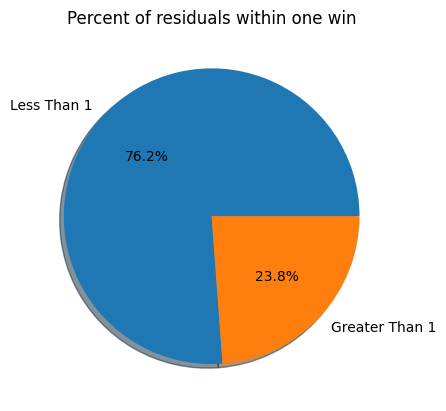

In [30]:
def pie_residuals():
    """
    Create a pie chart to visualize the percentage of residuals within one win.
    
    - Calculate the residuals (difference between actual and predicted values).
    - Categorize the residuals into two groups: less than one and greater than or equal to one.
    - Create a pie chart to show the percentage of residuals in each group.
    """
    less_than_one = []  # Initialize an empty list to store residuals less than one
    greater_than_one = []  # Initialize an empty list to store residuals greater than or equal to one
    comparison_df = compare_preds()  # Retrieve the comparison DataFrame
    residuals = comparison_df['Actual'] - comparison_df['Predicted']  # Calculate the residuals
    
    # Categorize the residuals into two groups
    for i in residuals:
        if abs(i) < 1:
            less_than_one.append(i)  # Append to less_than_one if the absolute residual is less than one
        else:
            greater_than_one.append(i)  # Append to greater_than_one if the absolute residual is greater than or equal to one
    
    # Create a pie chart to show the percentage of residuals in each group
    plt.pie(
        [len(less_than_one), len(greater_than_one)], 
        labels=['Less Than 1', 'Greater Than 1'],  
        autopct="%1.1f%%", 
        shadow=True
    )
    plt.title('Percent of residuals within one win')  # Set the title of the pie chart
    plt.show()  # Display the pie chart

# Call the function to create and display the pie chart
pie_residuals()
# The pie chart shows that the model is preforming well as the majority of residuals are within one win


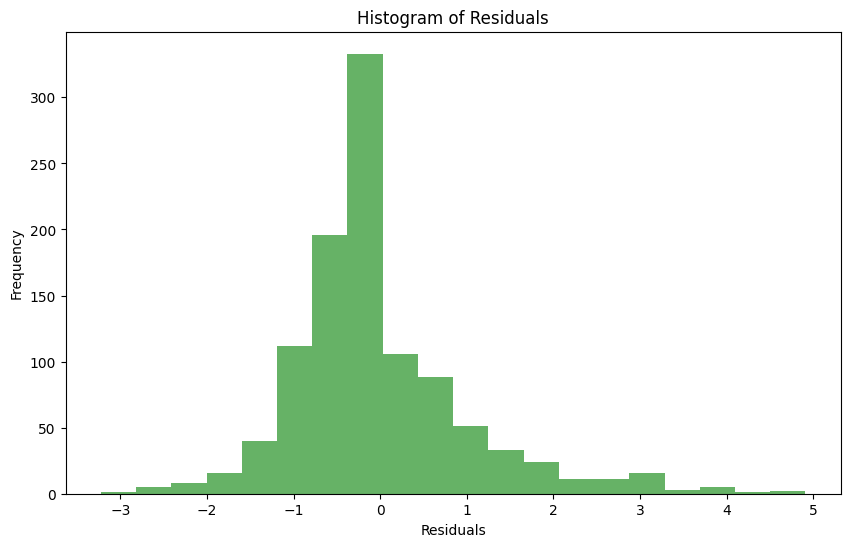

In [31]:
def histogram_of_residuals():
    """
    Create a histogram to visualize the distribution of residuals.
    
    - Retrieve the comparison DataFrame containing actual and predicted values.
    - Calculate the residuals (difference between actual and predicted values).
    - Create a histogram of the residuals with specified bins and transparency.
    - Set the labels and title of the histogram.
    - Display the histogram.
    """
    comparison_df = compare_preds()  # Retrieve the comparison DataFrame
    residuals = comparison_df['Actual'] - comparison_df['Predicted']  # Calculate the residuals
    
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.hist(residuals, bins=20, alpha=0.6, color='g')  # Create a histogram of residuals
    plt.xlabel('Residuals')  # Set the x-label
    plt.ylabel('Frequency')  # Set the y-label
    plt.title('Histogram of Residuals')  # Set the title of the histogram
    plt.show()  # Display the histogram

# Call the function to create and display the histogram of residuals
histogram_of_residuals()
# The majority of residuals are centered around 0, indicating that the model is preforming well
# The histogram is slightly skewed to the right, again indicating that the model is underpredicting 
# the number of wins for teams with a high number of wins

In [32]:
def list_teams_with_highest_residuals(high_low, number):
    """
    List the teams with the highest or lowest residuals.
    
    Args:
        high_low (bool): If True, list teams with the highest residuals; if False, list teams with the lowest residuals.
        number (int): The number of teams to list.
    
    Returns:
        pd.DataFrame: DataFrame containing the specified number of teams with the highest or lowest residuals.
    """
    comparison_df = compare_preds()  # Retrieve the comparison DataFrame
    comparison_df['Residuals'] = comparison_df['Actual'] - comparison_df['Predicted']  # Calculate the residuals
    
    # Sort the DataFrame by the absolute value of residuals in ascending or descending order
    sorted_df = comparison_df.reindex(comparison_df['Residuals'].sort_values(ascending=high_low).index)
    
    # Return the specified number of teams with the highest or lowest residuals
    return sorted_df.head(number)

# Call the function to list the top 15 teams with the highest residuals, the teams that underpreformed the most
list_teams_with_highest_residuals(True, 15)

,Team,Actual,Predicted,Residuals
681,"2018, Virginia",0.0,3.225618,-3.225618
284,"2012, Missouri",0.0,2.643294,-2.643294
968,"2023, Purdue",0.0,2.550056,-2.550056
412,"2014, Duke",0.0,2.543015,-2.543015
148,"2010, Kansas",1.0,3.468935,-2.468935
554,"2016, West Virginia",0.0,2.413457,-2.413457
998,"2024, Auburn",0.0,2.303901,-2.303901
631,"2017, Villanova",1.0,3.232231,-2.232231
584,"2016, Michigan St.",0.0,2.211208,-2.211208
866,"2022, Kentucky",0.0,2.160008,-2.160008


In [33]:
list_teams_with_highest_residuals(False, 15) 
# calling the function to list the top 15 teams with the lowest residuals, the teams that overpreformed the most

,Team,Actual,Predicted,Residuals
419,"2014, Connecticut",6.0,1.090981,4.909019
247,"2011, Connecticut",6.0,1.487617,4.512383
253,"2011, Butler",5.0,0.509679,4.490321
881,"2022, North Carolina",5.0,1.064370,3.935630
965,"2023, Connecticut",6.0,2.161465,3.838535
182,"2010, Butler",5.0,1.204231,3.795769
208,"2011, VCU",4.0,0.229847,3.770153
441,"2014, Kentucky",5.0,1.263840,3.736160
662,"2018, Loyola Chicago",4.0,0.436229,3.563771
551,"2016, Syracuse",4.0,0.531486,3.468514


Next I will be predicted results from the cancelled 2020 tournament to give a sense of what teams would have been the favorites

In [55]:
drop_table('stats_2020')
drop_table('teams_2020')
# dropping tables that will be created later so I can re-run the code if needed 

In [56]:
def get_2020_stats():
    """
    Fetch the 2020 team statistics from the specified URL and return it as a pandas DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame containing the 2020 team statistics.
    """
    data = requests.get(f'https://barttorvik.com/teamslicejson.php?year=2020&csv=1&type=R')  # Fetch data from the URL
    data = StringIO(data.text)  # Convert the text data to a StringIO object
    data = pd.read_csv(data)  # Read the data into a pandas DataFrame
    return data  # Return the DataFrame

def drop_columns():
    """
    Drop unnecessary columns from the 2020 team statistics DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame with specified columns dropped.
    """
    drops = ['Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', '64.8']  # Columns to drop
    data = get_2020_stats()  # Get the 2020 team statistics DataFrame
    data.drop(drops, axis=1, inplace=True)  # Drop the specified columns
    return data  # Return the modified DataFrame

def create_2020_csv():
    """
    Create a CSV file from the 2020 team statistics DataFrame with unnecessary columns dropped.
    """
    data = drop_columns()  # Get the modified DataFrame with columns dropped
    data.to_csv('stats_2020.csv', index=False)  # Save the DataFrame to a CSV file

def create_2020_stats_table():
    """
    Create the 'stats_2020' table in the database and populate it with data from the CSV file.
    
    - Define the SQL command to create the 'stats_2020' table.
    - Define the SQL command to copy data from the CSV file into the 'stats_2020' table.
    - Establish a connection to the database.
    - Execute the SQL commands to create the table and copy the data.
    - Close the database connection.
    """
    create_table = '''
    CREATE TABLE stats_2020 (
        school text,
        adjo numeric(16,12),
        adjd numeric (16,12),
        barthag numeric (15,12),
        record text,
        wins int,
        games_played int,
        efg_percentage numeric (3,1),
        efgd_percentage numeric (3,1),
        ftr numeric (3,1),
        ftrd numeric (3,1),
        to_percentage numeric (3,1),
        to_percentage_def numeric (3,1),
        orb_percentage numeric (3,1),
        drb_percentage numeric (3,1),
        two_point_percentage numeric (3,1),
        two_point_percentage_def numeric (3,1),
        three_point_percentage numeric (3,1),
        three_point_percentage_def numeric (3,1),
        def_block_percentage numeric (3,1),
        off_block_percentage numeric (3,1),
        ast_rate_off numeric (3,1),
        ast_rate_def numeric (3,1),
        three_pt_rate_off numeric (3,1),
        three_pt_rate_def numeric (3,1),
        adj_tempo numeric (3,1),
        year int,
        wab numeric (15, 12),
        ft_percentage numeric (3,1),
        ft_percentage_def numeric (3,1)
    ); 
    '''  # SQL command to create the 'stats_2020' table
    
    copy = '''
    COPY stats_2020
    FROM 'C:\\Users\\natha\\March Madness\\stats_2020.csv'
    WITH (FORMAT CSV, HEADER);
    '''  # SQL command to copy data from the CSV file into the 'stats_2020' table
    
    connection = connecting()  # Establish a connection to the database
    execute_query(connection, create_table)  # Execute the SQL command to create the table
    execute_query(connection, copy)  # Execute the SQL command to copy the data
    connection.close()  # Close the database connection

def get_2020_seeds():
    """
    Retrieve the list of 2020 team seeds from a text file.
    
    Returns:
        list: List of team seeds.
    """
    filename = 'seeds.txt'  # File containing the team seeds
    f = open(filename, "r", encoding="utf8")  # Open the file for reading
    seeds = f.readlines()  # Read all lines from the file
    f.close()  # Close the file
    seeds = [element.strip('\n') for element in seeds]  # Remove newline characters from each element
    return seeds  # Return the list of seeds

def get_2020_teams():
    """
    Retrieve the list of 2020 team names from a text file.
    
    Returns:
        list: List of team names.
    """
    filename = 'teams_2020.txt'  # File containing the team names
    f = open(filename, "r", encoding="utf8")  # Open the file for reading
    teams = f.readlines()  # Read all lines from the file
    f.close()  # Close the file
    teams = [element.strip('\n') for element in teams]  # Remove newline characters from each element
    return teams  # Return the list of teams

def create_2020_teams_csv():
    """
    Create a CSV file containing the 2020 team names and their corresponding seeds.
    """
    csv_file = open("teams_2020_table.csv", "w", newline="", encoding="utf-8")  # Open the CSV file for writing
    csv_writer = csv.writer(csv_file)  # Create a CSV writer object
    csv_writer.writerow(["Team", "Seed"])  # Write the header row
    teams = get_2020_teams()  # Get the list of team names
    seeds = get_2020_seeds()  # Get the list of team seeds
    for team, seed in zip(teams, seeds):
        team = team.strip()  # Remove leading/trailing whitespace from the team name
        seed = seed.strip()  # Remove leading/trailing whitespace from the seed
        csv_writer.writerow([team, seed])  # Write the team name and seed to the CSV file
    csv_file.close()  # Close the CSV file


def create_2020_teams_table():
    """
    Create the 'teams_2020' table in the database and populate it with data from a CSV file.
    
    - Define the SQL command to create the 'teams_2020' table.
    - Define the SQL command to copy data from the CSV file into the 'teams_2020' table.
    - Establish a connection to the database.
    - Execute the SQL commands to create the table and copy the data.
    - Close the database connection.
    """
    # Define the SQL command to create the 'teams_2020' table
    create_table = '''
    CREATE TABLE teams_2020 (
        team text,
        seed int
    ); 
    '''
    
    # Define the SQL command to copy data from the CSV file into the 'teams_2020' table
    copy = '''
    COPY teams_2020
    FROM 'C:\\Users\\natha\\March Madness\\teams_2020_table.csv'
    WITH (FORMAT CSV, HEADER);
    '''
    
    connection = connecting()  # Establish a connection to the database
    execute_query(connection, create_table)  # Execute the SQL command to create the table
    execute_query(connection, copy)  # Execute the SQL command to copy the data
    connection.close()  # Close the database connection

def get_joined_data():
    """
    Retrieve joined data from the 'stats_2020' and 'teams_2020' tables.
    
    - Define the SQL query to join the 'stats_2020' and 'teams_2020' tables.
    - Establish a connection to the database.
    - Execute the SQL query and fetch the results.
    - Return the query results.
    
    Returns:
        list: List of tuples containing the joined data.
    """
    # Define the SQL query to join the 'stats_2020' and 'teams_2020' tables
    query = '''
    SELECT s.*
    FROM stats_2020 AS s 
    JOIN teams_2020 AS t
    ON s.school = t.team;
    '''
    
    connection = connecting()  # Establish a connection to the database
    execute_query(connection, query)  # Execute the SQL query
    stat_results = read_query(connection, query)  # Fetch the query results
    return stat_results  # Return the query results

def make_2020_preds():
    """
    Make predictions for the 2020 teams using the trained model.
    
    - Load the trained model and selector from a file.
    - Transform the feature matrix using the selector.
    - Make predictions using the model.
    - Clip the predictions to a specified range.
    - Return the clipped predictions.
    
    Returns:
        np.ndarray: The clipped predictions.
    """
    model, selector = joblib.load('march_madness.joblib')  # Load the trained model and selector from a file
    x = selector.transform(get_x(get_joined_data))  # Transform the feature matrix using the selector
    preds = model.predict(x)  # Make predictions using the model
    preds = clip_predictions(model, x)  # Clip the predictions to the specified range
    return preds  # Return the clipped predictions

def get_2020_preds_df():
    """
    Create a DataFrame containing the 2020 teams and their predicted wins.
    
    - Retrieve the list of 2020 teams.
    - Make predictions for the 2020 teams.
    - Create a DataFrame with the team names and their predicted wins.
    - Return the DataFrame.
    
    Returns:
        pd.DataFrame: DataFrame containing the team names and their predicted wins.
    """
    teams = get_2020_teams()  # Retrieve the list of 2020 teams
    preds = make_2020_preds()  # Make predictions for the 2020 teams
    df = pd.DataFrame({'Team': teams, 'Predicted Wins': preds})  # Create a DataFrame with the team names and their predicted wins
    return df  # Return the DataFrame

In [57]:
create_2020_csv()
create_2020_stats_table()
create_2020_teams_csv()
create_2020_teams_table()
results=get_2020_preds_df()

# running all the needed functions


In [58]:
results=results.sort_values(by='Predicted Wins', ascending=False).head(20)
print(results) # printing the top 20 teams with the highest predicted wins for 2020

             Team  Predicted Wins
0          Kansas        2.940138
1         Gonzaga        2.463960
2          Baylor        2.423483
3          Dayton        2.221714
8            Duke        1.853272
7       Creighton        1.692584
9    Michigan St.        1.624195
4   San Diego St.        1.592527
16       Ohio St.        1.465558
6       Villanova        1.436610
5     Florida St.        1.415603
14     Louisville        1.393473
13         Oregon        1.293508
11       Maryland        1.229837
20  West Virginia        1.198201
17         Butler        1.119403
21       Penn St.        1.070700
19            BYU        1.058129
10     Seton Hall        1.054504
26        Houston        1.016588
